In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout, concatenate

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3, 7"

### Dataset

In [4]:
dataset = pd.read_csv('../../data/pollution.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [5]:
# data.tail(10)

### Dataset Information

In [6]:
print(list(data.columns))

['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']


### Pre-processing

In [7]:
# specify the number of lag hours
n_hours = 24*3
K = 24
n_features = data.shape[1]

#### Stage

In [8]:
# Pre-processing
# Stage --> 8 stages
pms = dataset[['pollution']]
print("pms.shape:", pms.shape)

# stages_supervised = stage_series_to_supervised(stages, n_hours, K, 1)
pms_supervised = series_to_supervised(pms, n_hours, K)
pms_supervised.reset_index(drop=True, inplace=True)
print("pms_supervised.shape:", pms_supervised.shape)

pms.shape: (43800, 1)
pms_supervised.shape: (43705, 96)


In [9]:
# pms_supervised

#### Prior known covariates (9)

In [10]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
prior_known_cov = data[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]
print("prior_known_cov.shape:", prior_known_cov.shape)

prior_known_cov_supervised = series_to_supervised(prior_known_cov, n_hours, K)
print("prior_known_cov_supervised.shape:", prior_known_cov_supervised.shape)

prior_known_cov.shape: (43800, 10)
prior_known_cov_supervised.shape: (43705, 960)


In [11]:
prior_known_cov_supervised.reset_index(drop=True, inplace=True)
prior_known_cov_supervised.columns = ['past_known_cov_' + i for i in list(prior_known_cov_supervised.columns)]

In [12]:
prior_known_cov_supervised

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var10(t-72),...,past_known_cov_var1(t+23),past_known_cov_var2(t+23),past_known_cov_var3(t+23),past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23),past_known_cov_var10(t+23)
0,-16.0,-4.0,1020.0,1.79,0.0,0.0,0.0,0.0,1.0,0.0,...,-22.0,-16.0,1033.0,23.70,0.0,0.0,0.0,1.0,0.0,0.0
1,-15.0,-4.0,1020.0,2.68,0.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-17.0,1033.0,26.83,0.0,0.0,0.0,1.0,0.0,0.0
2,-11.0,-5.0,1021.0,3.57,0.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-14.0,1033.0,4.02,0.0,0.0,1.0,0.0,0.0,0.0
3,-7.0,-5.0,1022.0,5.36,1.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1034.0,8.04,0.0,0.0,1.0,0.0,0.0,0.0
4,-7.0,-5.0,1022.0,6.25,2.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1033.0,13.85,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-9.0,-3.0,1026.0,3.57,0.0,0.0,0.0,0.0,0.0,1.0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43701,-9.0,-4.0,1026.0,4.46,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43702,-7.0,-4.0,1025.0,5.35,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43703,-9.0,-5.0,1025.0,6.24,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
prior_known_future_cov = prior_known_cov_supervised.iloc[:, n_hours*prior_known_cov.shape[1]:]
prior_known_future_cov

,past_known_cov_var1(t),past_known_cov_var2(t),past_known_cov_var3(t),past_known_cov_var4(t),past_known_cov_var5(t),past_known_cov_var6(t),past_known_cov_var7(t),past_known_cov_var8(t),past_known_cov_var9(t),past_known_cov_var10(t),...,past_known_cov_var1(t+23),past_known_cov_var2(t+23),past_known_cov_var3(t+23),past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23),past_known_cov_var10(t+23)
0,-26,-17.0,1035.0,201.58,0,0,0,1,0,0,...,-22.0,-16.0,1033.0,23.70,0.0,0.0,0.0,1.0,0.0,0.0
1,-26,-18.0,1035.0,205.60,0,0,0,1,0,0,...,-25.0,-17.0,1033.0,26.83,0.0,0.0,0.0,1.0,0.0,0.0
2,-26,-19.0,1035.0,208.73,0,0,0,1,0,0,...,-25.0,-14.0,1033.0,4.02,0.0,0.0,1.0,0.0,0.0,0.0
3,-27,-18.0,1035.0,213.65,0,0,0,1,0,0,...,-26.0,-14.0,1034.0,8.04,0.0,0.0,1.0,0.0,0.0,0.0
4,-27,-19.0,1035.0,218.57,0,0,0,1,0,0,...,-26.0,-14.0,1033.0,13.85,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-11,5.0,1022.0,12.96,0,0,0,1,0,0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43701,-12,4.0,1023.0,21.90,0,0,0,1,0,0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43702,-21,2.0,1025.0,31.73,0,0,0,1,0,0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43703,-22,0.0,1026.0,38.88,0,0,0,1,0,0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [14]:
prior_known_future_cov.shape

(43705, 240)

### N_out, N_in, K

In [15]:
# specify the number of lag hours
n_features = pms.shape[1] + prior_known_cov.shape[1]
n_features

11

### Concatenation

In [16]:
past_prior_known_cov_supervised = prior_known_cov_supervised.iloc[:, :n_hours*prior_known_cov.shape[1]]

In [17]:
columns = []
for i in range(n_hours):
    #columns = columns + past_prior_unknown_cov_supervised.columns[i*prior_unknown_cov.shape[1]:(i+1)*prior_unknown_cov.shape[1]].tolist()
    columns = columns + past_prior_known_cov_supervised.columns[i*prior_known_cov.shape[1]:(i+1)*prior_known_cov.shape[1]].tolist()
# columns

In [18]:
past_unknown_known_cov = concat([
                                #past_prior_unknown_cov_supervised, 
                                past_prior_known_cov_supervised],
                                axis=1)

In [19]:
past_unknown_known_cov

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var10(t-72),...,past_known_cov_var1(t-1),past_known_cov_var2(t-1),past_known_cov_var3(t-1),past_known_cov_var4(t-1),past_known_cov_var5(t-1),past_known_cov_var6(t-1),past_known_cov_var7(t-1),past_known_cov_var8(t-1),past_known_cov_var9(t-1),past_known_cov_var10(t-1)
0,-16.0,-4.0,1020.0,1.79,0.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-15.0,1035.0,198.45,0.0,0.0,0.0,1.0,0.0,0.0
1,-15.0,-4.0,1020.0,2.68,0.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-17.0,1035.0,201.58,0.0,0.0,0.0,1.0,0.0,0.0
2,-11.0,-5.0,1021.0,3.57,0.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-18.0,1035.0,205.60,0.0,0.0,0.0,1.0,0.0,0.0
3,-7.0,-5.0,1022.0,5.36,1.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-19.0,1035.0,208.73,0.0,0.0,0.0,1.0,0.0,0.0
4,-7.0,-5.0,1022.0,6.25,2.0,0.0,0.0,0.0,1.0,0.0,...,-27.0,-18.0,1035.0,213.65,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-9.0,-3.0,1026.0,3.57,0.0,0.0,0.0,0.0,0.0,1.0,...,-8.0,6.0,1021.0,5.81,0.0,0.0,0.0,1.0,0.0,0.0
43701,-9.0,-4.0,1026.0,4.46,0.0,0.0,0.0,0.0,0.0,1.0,...,-11.0,5.0,1022.0,12.96,0.0,0.0,0.0,1.0,0.0,0.0
43702,-7.0,-4.0,1025.0,5.35,0.0,0.0,0.0,0.0,0.0,1.0,...,-12.0,4.0,1023.0,21.90,0.0,0.0,0.0,1.0,0.0,0.0
43703,-9.0,-5.0,1025.0,6.24,0.0,0.0,0.0,0.0,0.0,1.0,...,-21.0,2.0,1025.0,31.73,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
# non_stages_supervised.reset_index(drop=True, inplace=True)
# stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([past_unknown_known_cov, pms_supervised.iloc[:, :]], axis=1)

In [21]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (43705, 816)


In [22]:
all_data

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var10(t-72),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
0,-16.0,-4.0,1020.0,1.79,0.0,0.0,0.0,0.0,1.0,0.0,...,41.0,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0
1,-15.0,-4.0,1020.0,2.68,0.0,0.0,0.0,0.0,1.0,0.0,...,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0
2,-11.0,-5.0,1021.0,3.57,0.0,0.0,0.0,0.0,1.0,0.0,...,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0
3,-7.0,-5.0,1022.0,5.36,1.0,0.0,0.0,0.0,1.0,0.0,...,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0
4,-7.0,-5.0,1022.0,6.25,2.0,0.0,0.0,0.0,1.0,0.0,...,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-9.0,-3.0,1026.0,3.57,0.0,0.0,0.0,0.0,0.0,1.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
43701,-9.0,-4.0,1026.0,4.46,0.0,0.0,0.0,0.0,0.0,1.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
43702,-7.0,-4.0,1025.0,5.35,0.0,0.0,0.0,0.0,0.0,1.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0
43703,-9.0,-5.0,1025.0,6.24,0.0,0.0,0.0,0.0,0.0,1.0,...,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0,8.0


### Train & Test set

In [23]:
all_data = all_data.values
future_covariates = prior_known_future_cov.values

In [24]:
n_train_hours = int(len(data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]    # 0 column is the rainfall to measure heavy/medium/light
test = all_data[n_train_hours:, :]

n_train_hours: 35040


In [25]:
train_future_cov = prior_known_future_cov.iloc[:n_train_hours, :]
test_future_cov = prior_known_future_cov.iloc[n_train_hours:, :] 

In [26]:
test_future_cov.shape

(8665, 240)

### Normalization

In [27]:
n_hours

72

In [28]:
n_features

11

In [29]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (35040, 792) (35040, 24) (8665, 792) (8665, 24)


In [30]:
# normalize features
scaler1 = MinMaxScaler(feature_range=(0, 1))

train_future_cov = scaler1.fit_transform(train_future_cov)
test_future_cov = scaler1.fit_transform(test_future_cov)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (35040, 240) (8665, 240)


In [31]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (35040, 72, 11) (35040, 24) (8665, 72, 11) (8665, 24)


In [32]:
train_future_cov = train_future_cov.reshape(train_future_cov.shape[0], K, -1)
test_future_cov = test_future_cov.reshape(test_future_cov.shape[0], K, -1)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (35040, 24, 10) (8665, 24, 10)


In [33]:
# train_y = train_y.reshape((train_y.shape[0], K, -1))
# test_y = test_y.reshape((test_y.shape[0], K, -1))
# print(train_y.shape, test_y.shape)

In [33]:
# past_inputs

### Model

In [35]:
# Encoding the past
past_inputs = tf.keras.Input(shape=(n_hours, n_features), name='past_inputs')
encoder = tf.keras.layers.Conv1D(filters=256, 
                                 kernel_size=2, 
                                 activation='relu', 
                                 padding='same', 
                                 kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(past_inputs)
encoder = tf.keras.layers.Conv1D(filters=128, 
                                 kernel_size=2, 
                                 activation='relu', 
                                 padding='same', 
                                 kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)
encoder = tf.keras.layers.Conv1D(filters=64, 
                                 kernel_size=2, 
                                 activation='relu', 
                                 padding='same', 
                                 kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)
encoder = tf.keras.layers.Conv1D(filters=train_future_cov.shape[2], 
                                 kernel_size=2, 
                                 activation='relu', 
                                 padding='same', 
                                 kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)


# Combine past + future
future_inputs = tf.keras.Input(shape=(K, prior_known_cov.shape[1]), name='future_inputs')

past_future_input = concatenate([encoder, future_inputs], axis=1)


# decoder
decoder = tf.keras.layers.Conv1D(filters=128, 
                                  kernel_size=2, 
                                  activation='relu', 
                                  padding='same', 
                                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(past_future_input)
decoder = tf.keras.layers.Conv1D(filters=64, 
                                  kernel_size=2, 
                                  activation='relu', 
                                  padding='same', 
                                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)
decoder = tf.keras.layers.Conv1D(filters=32, 
                                  kernel_size=2, 
                                  activation='relu', 
                                  padding='same', 
                                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)
decoder = tf.keras.layers.Conv1D(filters=16, 
                                  kernel_size=2, 
                                  activation='relu', 
                                  padding='same', 
                                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)

fc = layers.Flatten()(decoder)

# final output
fc = tf.keras.layers.Dense(256, activation='relu')(fc)
fc = tf.keras.layers.Dense(128, activation='relu')(fc)
fc = tf.keras.layers.Dense(64, activation='relu')(fc)
output = tf.keras.layers.Dense(train_y.shape[1])(fc)

model = tf.keras.models.Model(inputs=[past_inputs, future_inputs], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
past_inputs (InputLayer)        [(None, 72, 11)]     0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 72, 256)      5888        past_inputs[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 72, 128)      65664       conv1d_4[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 72, 64)       16448       conv1d_5[0][0]                   
______________________________________________________________________________________________

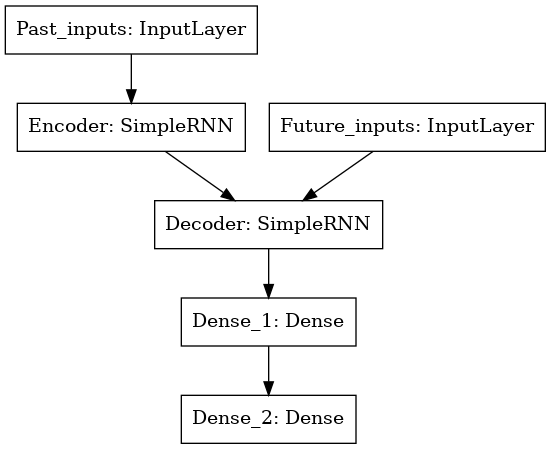

In [51]:
tf.keras.utils.plot_model(
    model,
#     to_file='model_rnn_plot_24.png',
    show_shapes=False,

    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
#     layer_range=None,
#     show_layer_activations=False
)

Epoch 1/6000


2023-02-05 15:03:53.107935: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-05 15:03:53.360367: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-05 15:03:54.386585: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-02-05 15:03:54.583346: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.07948, saving model to saved_model/cnn_encoder_decoder_24h_pm25.h5
69/69 - 50s - loss: 0.0590 - mae: 0.0662 - val_loss: 0.0499 - val_mae: 0.0795
Epoch 2/6000

Epoch 00002: val_mae improved from 0.07948 to 0.06548, saving model to saved_model/cnn_encoder_decoder_24h_pm25.h5
69/69 - 2s - loss: 0.0307 - mae: 0.0491 - val_loss: 0.0266 - val_mae: 0.0655
Epoch 3/6000

Epoch 00003: val_mae improved from 0.06548 to 0.05769, saving model to saved_model/cnn_encoder_decoder_24h_pm25.h5
69/69 - 2s - loss: 0.0172 - mae: 0.0429 - val_loss: 0.0183 - val_mae: 0.0577
Epoch 4/6000

Epoch 00004: val_mae improved from 0.05769 to 0.05461, saving model to saved_model/cnn_encoder_decoder_24h_pm25.h5
69/69 - 2s - loss: 0.0124 - mae: 0.0391 - val_loss: 0.0152 - val_mae: 0.0546
Epoch 5/6000

Epoch 00005: val_mae improved from 0.05461 to 0.05386, saving model to saved_model/cnn_encoder_decoder_24h_pm25.h5
69/69 - 2s - loss: 0.0106 - mae: 0.0378 - val_loss: 0.0136 - va

Epoch 55/6000

Epoch 00055: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0030 - mae: 0.0276 - val_loss: 0.0086 - val_mae: 0.0545
Epoch 56/6000

Epoch 00056: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0030 - mae: 0.0276 - val_loss: 0.0087 - val_mae: 0.0544
Epoch 57/6000

Epoch 00057: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0030 - mae: 0.0274 - val_loss: 0.0080 - val_mae: 0.0536
Epoch 58/6000

Epoch 00058: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0030 - mae: 0.0275 - val_loss: 0.0083 - val_mae: 0.0535
Epoch 59/6000

Epoch 00059: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0029 - mae: 0.0271 - val_loss: 0.0088 - val_mae: 0.0553
Epoch 60/6000

Epoch 00060: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0029 - mae: 0.0272 - val_loss: 0.0082 - val_mae: 0.0537
Epoch 61/6000

Epoch 00061: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0029 - mae: 0.0272 - val_loss: 0.0085 - val_mae: 0.0541
Epoch 

Epoch 113/6000

Epoch 00113: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0019 - mae: 0.0231 - val_loss: 0.0085 - val_mae: 0.0563
Epoch 114/6000

Epoch 00114: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0019 - mae: 0.0228 - val_loss: 0.0085 - val_mae: 0.0568
Epoch 115/6000

Epoch 00115: val_mae did not improve from 0.05052
69/69 - 2s - loss: 0.0019 - mae: 0.0227 - val_loss: 0.0086 - val_mae: 0.0564
Epoch 116/6000

Epoch 00116: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0019 - mae: 0.0229 - val_loss: 0.0082 - val_mae: 0.0563
Epoch 117/6000

Epoch 00117: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0019 - mae: 0.0227 - val_loss: 0.0085 - val_mae: 0.0573
Epoch 118/6000

Epoch 00118: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0019 - mae: 0.0227 - val_loss: 0.0084 - val_mae: 0.0573
Epoch 119/6000

Epoch 00119: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0019 - mae: 0.0230 - val_loss: 0.0089 - val_mae: 0.0569

Epoch 171/6000

Epoch 00171: val_mae did not improve from 0.05052
69/69 - 2s - loss: 0.0015 - mae: 0.0202 - val_loss: 0.0085 - val_mae: 0.0580
Epoch 172/6000

Epoch 00172: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0015 - mae: 0.0203 - val_loss: 0.0084 - val_mae: 0.0571
Epoch 173/6000

Epoch 00173: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0015 - mae: 0.0203 - val_loss: 0.0083 - val_mae: 0.0566
Epoch 174/6000

Epoch 00174: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0015 - mae: 0.0200 - val_loss: 0.0086 - val_mae: 0.0580
Epoch 175/6000

Epoch 00175: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0015 - mae: 0.0203 - val_loss: 0.0087 - val_mae: 0.0597
Epoch 176/6000

Epoch 00176: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0015 - mae: 0.0203 - val_loss: 0.0086 - val_mae: 0.0576
Epoch 177/6000

Epoch 00177: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0015 - mae: 0.0202 - val_loss: 0.0086 - val_mae: 0.0576

Epoch 229/6000

Epoch 00229: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0013 - mae: 0.0192 - val_loss: 0.0087 - val_mae: 0.0588
Epoch 230/6000

Epoch 00230: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0014 - mae: 0.0193 - val_loss: 0.0087 - val_mae: 0.0582
Epoch 231/6000

Epoch 00231: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0013 - mae: 0.0188 - val_loss: 0.0086 - val_mae: 0.0579
Epoch 232/6000

Epoch 00232: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0013 - mae: 0.0185 - val_loss: 0.0085 - val_mae: 0.0580
Epoch 233/6000

Epoch 00233: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0013 - mae: 0.0187 - val_loss: 0.0089 - val_mae: 0.0594
Epoch 234/6000

Epoch 00234: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0013 - mae: 0.0189 - val_loss: 0.0084 - val_mae: 0.0582
Epoch 235/6000

Epoch 00235: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0013 - mae: 0.0187 - val_loss: 0.0086 - val_mae: 0.0583

Epoch 287/6000

Epoch 00287: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0012 - mae: 0.0179 - val_loss: 0.0088 - val_mae: 0.0591
Epoch 288/6000

Epoch 00288: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0012 - mae: 0.0177 - val_loss: 0.0087 - val_mae: 0.0588
Epoch 289/6000

Epoch 00289: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0012 - mae: 0.0177 - val_loss: 0.0089 - val_mae: 0.0590
Epoch 290/6000

Epoch 00290: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0012 - mae: 0.0179 - val_loss: 0.0088 - val_mae: 0.0593
Epoch 291/6000

Epoch 00291: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0012 - mae: 0.0178 - val_loss: 0.0088 - val_mae: 0.0593
Epoch 292/6000

Epoch 00292: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0012 - mae: 0.0177 - val_loss: 0.0090 - val_mae: 0.0592
Epoch 293/6000

Epoch 00293: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0012 - mae: 0.0180 - val_loss: 0.0087 - val_mae: 0.0587

Epoch 345/6000

Epoch 00345: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0011 - mae: 0.0171 - val_loss: 0.0090 - val_mae: 0.0598
Epoch 346/6000

Epoch 00346: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0012 - mae: 0.0177 - val_loss: 0.0091 - val_mae: 0.0596
Epoch 347/6000

Epoch 00347: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0011 - mae: 0.0177 - val_loss: 0.0089 - val_mae: 0.0598
Epoch 348/6000

Epoch 00348: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0011 - mae: 0.0170 - val_loss: 0.0090 - val_mae: 0.0596
Epoch 349/6000

Epoch 00349: val_mae did not improve from 0.05052
69/69 - 2s - loss: 0.0011 - mae: 0.0172 - val_loss: 0.0090 - val_mae: 0.0594
Epoch 350/6000

Epoch 00350: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0011 - mae: 0.0171 - val_loss: 0.0089 - val_mae: 0.0606
Epoch 351/6000

Epoch 00351: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0011 - mae: 0.0176 - val_loss: 0.0089 - val_mae: 0.0596

Epoch 403/6000

Epoch 00403: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0011 - mae: 0.0170 - val_loss: 0.0089 - val_mae: 0.0600
Epoch 404/6000

Epoch 00404: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0010 - mae: 0.0166 - val_loss: 0.0090 - val_mae: 0.0601
Epoch 405/6000

Epoch 00405: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0011 - mae: 0.0171 - val_loss: 0.0089 - val_mae: 0.0594
Epoch 406/6000

Epoch 00406: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0011 - mae: 0.0166 - val_loss: 0.0091 - val_mae: 0.0601
Epoch 407/6000

Epoch 00407: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0011 - mae: 0.0166 - val_loss: 0.0091 - val_mae: 0.0605
Epoch 408/6000

Epoch 00408: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0010 - mae: 0.0164 - val_loss: 0.0092 - val_mae: 0.0602
Epoch 409/6000

Epoch 00409: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0010 - mae: 0.0166 - val_loss: 0.0091 - val_mae: 0.0604

Epoch 461/6000

Epoch 00461: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0010 - mae: 0.0164 - val_loss: 0.0088 - val_mae: 0.0596
Epoch 462/6000

Epoch 00462: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0010 - mae: 0.0163 - val_loss: 0.0092 - val_mae: 0.0607
Epoch 463/6000

Epoch 00463: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0010 - mae: 0.0165 - val_loss: 0.0089 - val_mae: 0.0604
Epoch 464/6000

Epoch 00464: val_mae did not improve from 0.05052
69/69 - 2s - loss: 0.0010 - mae: 0.0164 - val_loss: 0.0093 - val_mae: 0.0606
Epoch 465/6000

Epoch 00465: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.9697e-04 - mae: 0.0161 - val_loss: 0.0091 - val_mae: 0.0603
Epoch 466/6000

Epoch 00466: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.9822e-04 - mae: 0.0162 - val_loss: 0.0092 - val_mae: 0.0607
Epoch 467/6000

Epoch 00467: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0010 - mae: 0.0165 - val_loss: 0.0090 - val_mae

Epoch 518/6000

Epoch 00518: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.5019e-04 - mae: 0.0157 - val_loss: 0.0092 - val_mae: 0.0610
Epoch 519/6000

Epoch 00519: val_mae did not improve from 0.05052
69/69 - 2s - loss: 9.6318e-04 - mae: 0.0160 - val_loss: 0.0094 - val_mae: 0.0619
Epoch 520/6000

Epoch 00520: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.5950e-04 - mae: 0.0159 - val_loss: 0.0091 - val_mae: 0.0603
Epoch 521/6000

Epoch 00521: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.6361e-04 - mae: 0.0160 - val_loss: 0.0092 - val_mae: 0.0610
Epoch 522/6000

Epoch 00522: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.6252e-04 - mae: 0.0160 - val_loss: 0.0095 - val_mae: 0.0612
Epoch 523/6000

Epoch 00523: val_mae did not improve from 0.05052
69/69 - 1s - loss: 0.0010 - mae: 0.0166 - val_loss: 0.0093 - val_mae: 0.0615
Epoch 524/6000

Epoch 00524: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.9000e-04 - mae: 0.0164 - val_loss: 

Epoch 574/6000

Epoch 00574: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.2877e-04 - mae: 0.0156 - val_loss: 0.0093 - val_mae: 0.0615
Epoch 575/6000

Epoch 00575: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.4053e-04 - mae: 0.0159 - val_loss: 0.0090 - val_mae: 0.0605
Epoch 576/6000

Epoch 00576: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.3557e-04 - mae: 0.0158 - val_loss: 0.0091 - val_mae: 0.0612
Epoch 577/6000

Epoch 00577: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.6780e-04 - mae: 0.0163 - val_loss: 0.0092 - val_mae: 0.0608
Epoch 578/6000

Epoch 00578: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.3084e-04 - mae: 0.0157 - val_loss: 0.0092 - val_mae: 0.0606
Epoch 579/6000

Epoch 00579: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.1972e-04 - mae: 0.0155 - val_loss: 0.0092 - val_mae: 0.0614
Epoch 580/6000

Epoch 00580: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.5232e-04 - mae: 0.0161 - val_lo

Epoch 630/6000

Epoch 00630: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.9810e-04 - mae: 0.0154 - val_loss: 0.0092 - val_mae: 0.0612
Epoch 631/6000

Epoch 00631: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.9599e-04 - mae: 0.0154 - val_loss: 0.0092 - val_mae: 0.0608
Epoch 632/6000

Epoch 00632: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.1265e-04 - mae: 0.0157 - val_loss: 0.0094 - val_mae: 0.0631
Epoch 633/6000

Epoch 00633: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.6440e-04 - mae: 0.0165 - val_loss: 0.0092 - val_mae: 0.0609
Epoch 634/6000

Epoch 00634: val_mae did not improve from 0.05052
69/69 - 2s - loss: 8.9423e-04 - mae: 0.0154 - val_loss: 0.0092 - val_mae: 0.0606
Epoch 635/6000

Epoch 00635: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.8028e-04 - mae: 0.0151 - val_loss: 0.0093 - val_mae: 0.0611
Epoch 636/6000

Epoch 00636: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.8543e-04 - mae: 0.0152 - val_lo

Epoch 686/6000

Epoch 00686: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.6497e-04 - mae: 0.0150 - val_loss: 0.0093 - val_mae: 0.0614
Epoch 687/6000

Epoch 00687: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.6118e-04 - mae: 0.0150 - val_loss: 0.0093 - val_mae: 0.0612
Epoch 688/6000

Epoch 00688: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.6301e-04 - mae: 0.0150 - val_loss: 0.0094 - val_mae: 0.0612
Epoch 689/6000

Epoch 00689: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.7209e-04 - mae: 0.0152 - val_loss: 0.0093 - val_mae: 0.0612
Epoch 690/6000

Epoch 00690: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.6253e-04 - mae: 0.0150 - val_loss: 0.0094 - val_mae: 0.0613
Epoch 691/6000

Epoch 00691: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.8251e-04 - mae: 0.0154 - val_loss: 0.0091 - val_mae: 0.0609
Epoch 692/6000

Epoch 00692: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.7208e-04 - mae: 0.0152 - val_lo

Epoch 742/6000

Epoch 00742: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.4633e-04 - mae: 0.0149 - val_loss: 0.0092 - val_mae: 0.0612
Epoch 743/6000

Epoch 00743: val_mae did not improve from 0.05052
69/69 - 1s - loss: 9.2311e-04 - mae: 0.0161 - val_loss: 0.0094 - val_mae: 0.0613
Epoch 744/6000

Epoch 00744: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.5894e-04 - mae: 0.0151 - val_loss: 0.0094 - val_mae: 0.0619
Epoch 745/6000

Epoch 00745: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.4637e-04 - mae: 0.0148 - val_loss: 0.0093 - val_mae: 0.0611
Epoch 746/6000

Epoch 00746: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.5177e-04 - mae: 0.0150 - val_loss: 0.0094 - val_mae: 0.0617
Epoch 747/6000

Epoch 00747: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.6585e-04 - mae: 0.0152 - val_loss: 0.0091 - val_mae: 0.0608
Epoch 748/6000

Epoch 00748: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.4958e-04 - mae: 0.0149 - val_lo

Epoch 798/6000

Epoch 00798: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.3892e-04 - mae: 0.0149 - val_loss: 0.0093 - val_mae: 0.0613
Epoch 799/6000

Epoch 00799: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.3521e-04 - mae: 0.0148 - val_loss: 0.0094 - val_mae: 0.0617
Epoch 800/6000

Epoch 00800: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.3861e-04 - mae: 0.0149 - val_loss: 0.0096 - val_mae: 0.0629
Epoch 801/6000

Epoch 00801: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.4490e-04 - mae: 0.0150 - val_loss: 0.0093 - val_mae: 0.0616
Epoch 802/6000

Epoch 00802: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.3626e-04 - mae: 0.0148 - val_loss: 0.0093 - val_mae: 0.0616
Epoch 803/6000

Epoch 00803: val_mae did not improve from 0.05052
69/69 - 2s - loss: 8.3991e-04 - mae: 0.0149 - val_loss: 0.0091 - val_mae: 0.0609
Epoch 804/6000

Epoch 00804: val_mae did not improve from 0.05052
69/69 - 2s - loss: 8.2848e-04 - mae: 0.0147 - val_lo

Epoch 854/6000

Epoch 00854: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.1090e-04 - mae: 0.0145 - val_loss: 0.0093 - val_mae: 0.0611
Epoch 855/6000

Epoch 00855: val_mae did not improve from 0.05052
69/69 - 2s - loss: 8.2944e-04 - mae: 0.0148 - val_loss: 0.0095 - val_mae: 0.0620
Epoch 856/6000

Epoch 00856: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.1539e-04 - mae: 0.0146 - val_loss: 0.0093 - val_mae: 0.0613
Epoch 857/6000

Epoch 00857: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.1341e-04 - mae: 0.0145 - val_loss: 0.0094 - val_mae: 0.0617
Epoch 858/6000

Epoch 00858: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.1425e-04 - mae: 0.0146 - val_loss: 0.0094 - val_mae: 0.0617
Epoch 859/6000

Epoch 00859: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.3458e-04 - mae: 0.0149 - val_loss: 0.0092 - val_mae: 0.0610
Epoch 860/6000

Epoch 00860: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.2166e-04 - mae: 0.0147 - val_lo

Epoch 910/6000

Epoch 00910: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.0367e-04 - mae: 0.0145 - val_loss: 0.0095 - val_mae: 0.0622
Epoch 911/6000

Epoch 00911: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.0139e-04 - mae: 0.0144 - val_loss: 0.0094 - val_mae: 0.0617
Epoch 912/6000

Epoch 00912: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.1150e-04 - mae: 0.0146 - val_loss: 0.0093 - val_mae: 0.0616
Epoch 913/6000

Epoch 00913: val_mae did not improve from 0.05052
69/69 - 2s - loss: 8.0373e-04 - mae: 0.0145 - val_loss: 0.0095 - val_mae: 0.0622
Epoch 914/6000

Epoch 00914: val_mae did not improve from 0.05052
69/69 - 1s - loss: 7.9614e-04 - mae: 0.0143 - val_loss: 0.0093 - val_mae: 0.0614
Epoch 915/6000

Epoch 00915: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.1156e-04 - mae: 0.0146 - val_loss: 0.0093 - val_mae: 0.0615
Epoch 916/6000

Epoch 00916: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.1316e-04 - mae: 0.0147 - val_lo

Epoch 966/6000

Epoch 00966: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.1222e-04 - mae: 0.0147 - val_loss: 0.0095 - val_mae: 0.0621
Epoch 967/6000

Epoch 00967: val_mae did not improve from 0.05052
69/69 - 1s - loss: 7.9217e-04 - mae: 0.0143 - val_loss: 0.0094 - val_mae: 0.0616
Epoch 968/6000

Epoch 00968: val_mae did not improve from 0.05052
69/69 - 1s - loss: 7.9779e-04 - mae: 0.0145 - val_loss: 0.0093 - val_mae: 0.0615
Epoch 969/6000

Epoch 00969: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.4430e-04 - mae: 0.0153 - val_loss: 0.0096 - val_mae: 0.0620
Epoch 970/6000

Epoch 00970: val_mae did not improve from 0.05052
69/69 - 1s - loss: 8.2168e-04 - mae: 0.0148 - val_loss: 0.0095 - val_mae: 0.0622
Epoch 971/6000

Epoch 00971: val_mae did not improve from 0.05052
69/69 - 1s - loss: 7.9152e-04 - mae: 0.0143 - val_loss: 0.0095 - val_mae: 0.0620
Epoch 972/6000

Epoch 00972: val_mae did not improve from 0.05052
69/69 - 1s - loss: 7.8094e-04 - mae: 0.0141 - val_lo

Epoch 1022/6000

Epoch 01022: val_mae did not improve from 0.05052
69/69 - 1s - loss: 7.7085e-04 - mae: 0.0140 - val_loss: 0.0096 - val_mae: 0.0623
Epoch 1023/6000

Epoch 01023: val_mae did not improve from 0.05052
69/69 - 2s - loss: 7.7559e-04 - mae: 0.0141 - val_loss: 0.0095 - val_mae: 0.0625
Epoch 1024/6000

Epoch 01024: val_mae did not improve from 0.05052
69/69 - 1s - loss: 7.7545e-04 - mae: 0.0141 - val_loss: 0.0095 - val_mae: 0.0619
Epoch 1025/6000

Epoch 01025: val_mae did not improve from 0.05052
69/69 - 1s - loss: 7.8281e-04 - mae: 0.0143 - val_loss: 0.0095 - val_mae: 0.0621
Epoch 1026/6000

Epoch 01026: val_mae did not improve from 0.05052
69/69 - 1s - loss: 7.8081e-04 - mae: 0.0142 - val_loss: 0.0095 - val_mae: 0.0620
Epoch 1027/6000

Epoch 01027: val_mae did not improve from 0.05052
69/69 - 1s - loss: 7.8804e-04 - mae: 0.0144 - val_loss: 0.0096 - val_mae: 0.0626
Epoch 1028/6000

Epoch 01028: val_mae did not improve from 0.05052
69/69 - 1s - loss: 7.8215e-04 - mae: 0.0143 -

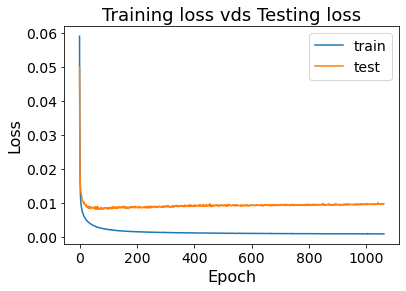

In [36]:
lr = 0.00001
EPOCHS = 6000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)

model.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
                optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/cnn_encoder_decoder_24h_pm25.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = model.fit(x=[train_X, train_future_cov], y=train_y, 
                    epochs=EPOCHS,
                    verbose=2,
                    validation_data=([test_X, test_future_cov], test_y),
                    batch_size = 512,
                    callbacks=[es, mc]
                   )

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vds Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Prediction

In [37]:
from tensorflow.keras.models import load_model

model = load_model('saved_model/cnn_encoder_decoder_24h_pm25.h5')

In [38]:
y_hat = model.predict([test_X, test_future_cov])

In [39]:
print(y_hat.shape)
print(test_y.shape)

(8665, 24)
(8665, 24)


In [41]:
inv_yhat = scaler.inverse_transform(y_hat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (8665, 24) (8665, 24)


### Performance

In [42]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 33.9
RMSE = 53.153
